In [14]:
# ==================== 第1部分: 导入库 ====================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
from tqdm import tqdm
import copy

# 设置随机种子
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    
set_seed(42)

# 检查GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda:0


In [15]:
# ==================== 第2部分: 定义数据集类 ====================
class EmotionDataset(Dataset):
    """面部情绪数据集"""
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir: 数据集根目录 (如 'mnt/7种面部表情_new/images/train')
            transform: 数据增强变换
        """
        self.root_dir = root_dir
        self.transform = transform
        
        # 情绪类别映射
        self.emotion_classes = ['Anger', 'Disgust', 'Fear', 'Happiness', 
                                'Sadness', 'Surprise', 'Neutral']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.emotion_classes)}
        
        # 收集所有图片路径和标签
        self.images = []
        self.labels = []
        
        for emotion in self.emotion_classes:
            emotion_dir = os.path.join(root_dir, emotion)
            if os.path.exists(emotion_dir):
                for img_name in os.listdir(emotion_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        img_path = os.path.join(emotion_dir, img_name)
                        self.images.append(img_path)
                        self.labels.append(self.class_to_idx[emotion])
        
        print(f"Loaded {len(self.images)} images from {root_dir}")
        self._print_class_distribution()
    
    def _print_class_distribution(self):
        """打印类别分布"""
        from collections import Counter
        label_counts = Counter(self.labels)
        print("\nClass distribution:")
        for emotion, idx in self.class_to_idx.items():
            count = label_counts[idx]
            print(f"  {emotion}: {count}")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        
        # 读取图像
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # 返回黑色图像作为fallback
            image = Image.new('RGB', (224, 224), (0, 0, 0))
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [23]:
# ==================== 第3部分: 数据增强（平衡版）====================
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    
    # 适度的几何变换
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),  # 15度（不是20度）
    transforms.RandomAffine(
        degrees=0, 
        translate=(0.1, 0.1),  # 保持0.1
        scale=(0.95, 1.05)     # 轻微缩放
    ),
    
    # 适度的颜色增强
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.1
    ),
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225]),
    
    # 轻微的随机擦除
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1))  # 降低概率
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])

print("✅ Balanced data augmentation configured!")


✅ Balanced data augmentation configured!


In [17]:

# ==================== 第4部分: 加载数据集 ====================
# 设置数据路径
train_dir = '/mnt/7种面部表情_new/images/train'
test_dir = '/mnt/7种面部表情_new/images/test'

# 创建数据集
train_dataset = EmotionDataset(train_dir, transform=train_transform)
test_dataset = EmotionDataset(test_dir, transform=test_transform)

# 创建数据加载器
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                         shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, 
                        shuffle=False, num_workers=4, pin_memory=True)

print(f"\nDataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Test batches: {len(test_loader)}")


Loaded 12271 images from /mnt/7种面部表情_new/images/train

Class distribution:
  Anger: 705
  Disgust: 717
  Fear: 281
  Happiness: 4772
  Sadness: 1982
  Surprise: 1290
  Neutral: 2524
Loaded 3068 images from /mnt/7种面部表情_new/images/test

Class distribution:
  Anger: 162
  Disgust: 160
  Fear: 74
  Happiness: 1185
  Sadness: 478
  Surprise: 329
  Neutral: 680

DataLoaders created:
  Train batches: 96
  Test batches: 24


In [18]:
# ==================== 第5部分: 定义Focal Loss ====================
class EmotionFocalLoss(nn.Module):
    """针对情绪识别的Focal Loss，特别提升Happiness类别"""
    def __init__(self, gamma=2, happiness_boost=2.0, alpha=None):
        super(EmotionFocalLoss, self).__init__()
        self.gamma = gamma
        self.happiness_boost = happiness_boost
        self.alpha = alpha
        
    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        p_t = torch.exp(-ce_loss)
        
        # Focal调制因子
        focal_loss = (1 - p_t) ** self.gamma * ce_loss
        
        # 为Happiness(类别3)增加额外权重
        happiness_mask = (targets == 3).float()
        weights = 1.0 + happiness_mask * (self.happiness_boost - 1.0)
        focal_loss = weights * focal_loss
        
        # 应用类别权重
        if self.alpha is not None:
            if self.alpha.device != inputs.device:
                self.alpha = self.alpha.to(inputs.device)
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * focal_loss
        
        return focal_loss.mean()

# 计算类别权重
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_dataset.labels),
    y=train_dataset.labels
)
class_weights = torch.FloatTensor(class_weights).to(device)
print(f"\nClass weights: {class_weights}")



Class weights: tensor([2.4865, 2.4449, 6.2384, 0.3674, 0.8845, 1.3589, 0.6945],
       device='cuda:0')


In [6]:
import torchvision
print(f"torchvision version: {torchvision.__version__}")
print(f"Available models: {[m for m in dir(torchvision.models) if not m.startswith('_')][:20]}")


torchvision version: 0.9.1+cu111
Available models: ['AlexNet', 'DenseNet', 'GoogLeNet', 'GoogLeNetOutputs', 'Inception3', 'InceptionOutputs', 'MNASNet', 'MobileNetV2', 'MobileNetV3', 'ResNet', 'ShuffleNetV2', 'SqueezeNet', 'VGG', 'alexnet', 'densenet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'detection']


In [24]:
# ==================== 第6部分: 模型定义（平衡版）====================
def create_emotion_model(num_classes=7, pretrained=True, freeze_features=True):
    """
    MobileNetV3 - 平衡版（防止过拟合但不欠拟合）
    """
    model = models.mobilenet_v3_large(pretrained=pretrained)
    
    if freeze_features:
        # 冻结70%的层（不是95%！）
        total_layers = len(list(model.features.children()))
        freeze_until = int(total_layers * 0.7)  # ← 70%，给模型更多学习空间
        
        for idx, child in enumerate(model.features.children()):
            if idx < freeze_until:
                for param in child.parameters():
                    param.requires_grad = False
    
    num_features = model.classifier[0].in_features
    
    # 适度的Dropout
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.4),      # ← 0.4（不是0.5）
        nn.Linear(num_features, 512),
        nn.Hardswish(),
        nn.BatchNorm1d(512),
        nn.Dropout(p=0.3),      # ← 0.3
        nn.Linear(512, num_classes)  # ← 去掉中间的256层，简化
    )
    
    return model

# 创建模型
model = create_emotion_model(num_classes=7, pretrained=True, freeze_features=True)
model = model.to(device)

# 打印信息
total_params, trainable_params = count_parameters(model)
frozen_params = total_params - trainable_params

print(f"\n{'='*60}")
print(f"Model: MobileNetV3-Large (Balanced Version)")
print(f"{'='*60}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {frozen_params:,}")
print(f"Trainable ratio: {trainable_params/total_params*100:.1f}%")
print(f"{'='*60}\n")



Model: MobileNetV3-Large (Balanced Version)
Total parameters: 3,468,599
Trainable parameters: 3,276,655
Frozen parameters: 191,944
Trainable ratio: 94.5%



In [20]:
# ==================== 第7部分: 定义训练函数 ====================
def train_model(model, train_loader, val_loader, criterion, optimizer, 
                scheduler, num_epochs=25, patience=5):
    """
    训练模型
    
    Args:
        model: 模型
        train_loader: 训练数据加载器
        val_loader: 验证数据加载器
        criterion: 损失函数
        optimizer: 优化器
        scheduler: 学习率调度器
        num_epochs: 训练轮数
        patience: 早停耐心值
    
    Returns:
        model: 训练好的模型
        history: 训练历史记录
    """
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_happiness_f1 = 0.0
    history = {
        'train_loss': [], 
        'train_acc': [],
        'val_loss': [], 
        'val_acc': [],
        'happiness_f1': [],
        'lr': []
    }
    
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 60)
        
        # 每个epoch包含训练和验证阶段
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []
            
            # 进度条
            desc = f'{phase.capitalize():5s}'
            pbar = tqdm(dataloader, desc=desc)
            
            for inputs, labels in pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                # 前向传播
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # 反向传播（仅训练阶段）
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # 统计
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                # 更新进度条
                pbar.set_postfix({'loss': f'{loss.item():.4f}'})
            
            # 计算epoch的平均指标
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            # 计算Happiness的F1-score
            from sklearn.metrics import f1_score
            try:
                happiness_f1 = f1_score(all_labels, all_preds, average=None)[3]
            except:
                happiness_f1 = 0.0
            
            # 记录历史
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
                history['lr'].append(optimizer.param_groups[0]['lr'])
                print(f'Train Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}')
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                history['happiness_f1'].append(happiness_f1)
                print(f'Val   Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f} | Happiness F1: {happiness_f1:.4f}')
                
                # 学习率调整
                if scheduler is not None:
                    scheduler.step(epoch_loss)
                    current_lr = optimizer.param_groups[0]['lr']
                    print(f'Learning Rate: {current_lr:.2e}')
                
                # 保存最佳模型（基于Happiness F1-score）
                if happiness_f1 > best_happiness_f1:
                    best_happiness_f1 = happiness_f1
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), 'best_emotion_model.pth')
                    print(f'✨ Best model saved! Happiness F1: {happiness_f1:.4f} ✨')
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                
                # 早停检查
                if epochs_no_improve >= patience:
                    print(f'\n⚠️  Early stopping triggered after {epoch+1} epochs')
                    print(f'   No improvement for {patience} consecutive epochs')
                    break
        
        # 如果触发早停，跳出外层循环
        if epochs_no_improve >= patience:
            break
    
    print(f'\n{"="*60}')
    print(f'Training Complete!')
    print(f'Best Validation Accuracy: {best_acc:.4f}')
    print(f'Best Happiness F1-Score: {best_happiness_f1:.4f}')
    print(f'{"="*60}')
    
    # 加载最佳模型权重
    model.load_state_dict(best_model_wts)
    return model, history


In [21]:
# ==================== 第8部分: 定义评估函数 ====================
def evaluate_model(model, data_loader, criterion, detailed=True):
    """
    评估模型性能
    
    Args:
        model: 模型
        data_loader: 数据加载器
        criterion: 损失函数
        detailed: 是否打印详细报告
    
    Returns:
        loss: 平均损失
        accuracy: 准确率
        happiness_f1: Happiness类别的F1分数
    """
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc='Evaluating'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # 获取预测结果和概率
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            running_loss += loss.item() * inputs.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # 计算指标
    avg_loss = running_loss / len(data_loader.dataset)
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    
    # 计算每个类别的F1-score
    from sklearn.metrics import f1_score, precision_score, recall_score
    f1_scores = f1_score(all_labels, all_preds, average=None)
    happiness_f1 = f1_scores[3]  # Happiness是类别3
    
    if detailed:
        print(f'\n{"="*60}')
        print(f'Evaluation Results')
        print(f'{"="*60}')
        print(f'Loss: {avg_loss:.4f}')
        print(f'Overall Accuracy: {accuracy:.4f}')
        print(f'Happiness F1-Score: {happiness_f1:.4f}')
        
        # 详细的分类报告
        emotion_classes = ['Anger', 'Disgust', 'Fear', 'Happiness', 
                          'Sadness', 'Surprise', 'Neutral']
        
        from sklearn.metrics import classification_report
        report = classification_report(all_labels, all_preds, 
                                      target_names=emotion_classes,
                                      digits=4)
        print(f'\n{"="*60}')
        print('Classification Report:')
        print(f'{"="*60}')
        print(report)
        
        # 每个类别的详细指标
        print(f'\n{"="*60}')
        print('Per-Class Metrics:')
        print(f'{"="*60}')
        precisions = precision_score(all_labels, all_preds, average=None)
        recalls = recall_score(all_labels, all_preds, average=None)
        
        print(f'{"Class":<12} {"Precision":<12} {"Recall":<12} {"F1-Score":<12}')
        print('-' * 60)
        for i, emotion in enumerate(emotion_classes):
            marker = ' ⭐' if i == 3 else ''  # 标记Happiness
            print(f'{emotion:<12} {precisions[i]:<12.4f} {recalls[i]:<12.4f} {f1_scores[i]:<12.4f}{marker}')
        
        # 绘制混淆矩阵
        plot_confusion_matrix(all_labels, all_preds, emotion_classes)
        
        # 绘制ROC曲线（针对Happiness）
        plot_roc_curve(all_labels, all_probs, emotion_classes)
    
    return avg_loss, accuracy, happiness_f1


def plot_confusion_matrix(y_true, y_pred, classes):
    """绘制混淆矩阵"""
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred)
    
    # 计算百分比
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # 绘制数量混淆矩阵
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes, ax=ax1)
    ax1.set_title('Confusion Matrix (Count)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('True Label', fontsize=12)
    ax1.set_xlabel('Predicted Label', fontsize=12)
    
    # 绘制百分比混淆矩阵
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='RdYlGn', 
                xticklabels=classes, yticklabels=classes, ax=ax2)
    ax2.set_title('Confusion Matrix (Percentage %)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('True Label', fontsize=12)
    ax2.set_xlabel('Predicted Label', fontsize=12)
    
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 打印Happiness的混淆情况
    print(f'\n{"="*60}')
    print('Happiness Confusion Analysis:')
    print(f'{"="*60}')
    happiness_idx = 3
    total_happiness = cm[happiness_idx].sum()
    correct_happiness = cm[happiness_idx, happiness_idx]
    print(f'Total Happiness samples: {total_happiness}')
    print(f'Correctly predicted: {correct_happiness} ({correct_happiness/total_happiness*100:.2f}%)')
    print(f'\nMisclassified as:')
    for i, emotion in enumerate(classes):
        if i != happiness_idx and cm[happiness_idx, i] > 0:
            print(f'  {emotion}: {cm[happiness_idx, i]} ({cm[happiness_idx, i]/total_happiness*100:.2f}%)')


def plot_roc_curve(y_true, y_probs, classes):
    """绘制ROC曲线（重点关注Happiness）"""
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import roc_curve, auc
    
    # 二值化标签
    y_true_bin = label_binarize(y_true, classes=range(len(classes)))
    y_probs = np.array(y_probs)
    
    plt.figure(figsize=(10, 8))
    
    # 为每个类别绘制ROC曲线
    for i, emotion in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        
        # Happiness用粗线和特殊颜色
        if i == 3:  # Happiness
            plt.plot(fpr, tpr, linewidth=3, color='red',
                    label=f'{emotion} (AUC = {roc_auc:.4f}) ⭐')
        else:
            plt.plot(fpr, tpr, linewidth=1, alpha=0.6,
                    label=f'{emotion} (AUC = {roc_auc:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves for All Emotions', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
    plt.show()


In [25]:
# ==================== 第9部分: 训练参数（平衡版）====================

# 提高学习率（让模型能够学习）
initial_lr = 3e-4  # ← 从1e-4提高到3e-4

# 适度的权重衰减
weight_decay = 1e-4  # ← 从5e-4降低到1e-4

# 定义损失函数
criterion = EmotionFocalLoss(gamma=2, happiness_boost=2.5, alpha=class_weights)

# 使用AdamW（更容易训练）
optimizer = optim.AdamW(
    model.parameters(), 
    lr=initial_lr, 
    weight_decay=weight_decay
)

# 温和的学习率调度
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.5,      # ← 0.5（不是0.3）
    patience=3,      # ← 3个epoch（不是2个）
    verbose=True,
    min_lr=1e-7
)

# 训练参数
num_epochs = 30
patience = 7

print("\n" + "="*60)
print("Balanced Training Configuration:")
print("="*60)
print(f"Initial learning rate: {initial_lr}")
print(f"Weight decay: {weight_decay}")
print(f"Optimizer: AdamW")
print(f"Epochs: {num_epochs}")
print(f"Early stopping patience: {patience}")
print(f"Batch size: {batch_size}")
print(f"Device: {device}")
print("="*60 + "\n")

print("🚀 Starting balanced training...\n")
model, history = train_model(
    model, 
    train_loader, 
    test_loader, 
    criterion, 
    optimizer, 
    scheduler,
    num_epochs=num_epochs, 
    patience=patience
)



Balanced Training Configuration:
Initial learning rate: 0.0003
Weight decay: 0.0001
Optimizer: AdamW
Epochs: 30
Early stopping patience: 7
Batch size: 128
Device: cuda:0

🚀 Starting balanced training...


Epoch 1/30
------------------------------------------------------------


Train: 100%|██████████| 96/96 [01:19<00:00,  1.21it/s, loss=1.2160]


Train Loss: 1.5427 | Acc: 0.3323


Val  : 100%|██████████| 24/24 [00:13<00:00,  1.80it/s, loss=1.3170]


Val   Loss: 1.4308 | Acc: 0.4371 | Happiness F1: 0.7131
Learning Rate: 3.00e-04
✨ Best model saved! Happiness F1: 0.7131 ✨

Epoch 2/30
------------------------------------------------------------


Train: 100%|██████████| 96/96 [01:18<00:00,  1.22it/s, loss=1.1434]


Train Loss: 1.1465 | Acc: 0.4977


Val  : 100%|██████████| 24/24 [00:14<00:00,  1.66it/s, loss=0.5420]


Val   Loss: 1.0767 | Acc: 0.5518 | Happiness F1: 0.7723
Learning Rate: 3.00e-04
✨ Best model saved! Happiness F1: 0.7723 ✨

Epoch 3/30
------------------------------------------------------------


Train: 100%|██████████| 96/96 [01:22<00:00,  1.16it/s, loss=0.9450]


Train Loss: 0.9551 | Acc: 0.5638


Val  : 100%|██████████| 24/24 [00:15<00:00,  1.52it/s, loss=0.5330]


Val   Loss: 0.9604 | Acc: 0.5789 | Happiness F1: 0.7469
Learning Rate: 3.00e-04

Epoch 4/30
------------------------------------------------------------


Train: 100%|██████████| 96/96 [01:30<00:00,  1.06it/s, loss=0.7519]


Train Loss: 0.8401 | Acc: 0.5995


Val  : 100%|██████████| 24/24 [00:15<00:00,  1.60it/s, loss=0.7011]


Val   Loss: 0.8802 | Acc: 0.6050 | Happiness F1: 0.8014
Learning Rate: 3.00e-04
✨ Best model saved! Happiness F1: 0.8014 ✨

Epoch 5/30
------------------------------------------------------------


Train: 100%|██████████| 96/96 [01:27<00:00,  1.09it/s, loss=0.7598]


Train Loss: 0.7597 | Acc: 0.6275


Val  : 100%|██████████| 24/24 [00:16<00:00,  1.46it/s, loss=0.7680]


Val   Loss: 0.8150 | Acc: 0.6226 | Happiness F1: 0.8006
Learning Rate: 3.00e-04

Epoch 6/30
------------------------------------------------------------


Train: 100%|██████████| 96/96 [01:25<00:00,  1.13it/s, loss=0.9282]


Train Loss: 0.6957 | Acc: 0.6443


Val  : 100%|██████████| 24/24 [00:14<00:00,  1.69it/s, loss=0.6859]


Val   Loss: 0.8999 | Acc: 0.5968 | Happiness F1: 0.8018
Learning Rate: 3.00e-04
✨ Best model saved! Happiness F1: 0.8018 ✨

Epoch 7/30
------------------------------------------------------------


Train: 100%|██████████| 96/96 [01:21<00:00,  1.18it/s, loss=0.6644]


Train Loss: 0.6234 | Acc: 0.6632


Val  : 100%|██████████| 24/24 [00:13<00:00,  1.77it/s, loss=0.4507]


Val   Loss: 0.7790 | Acc: 0.6917 | Happiness F1: 0.8447
Learning Rate: 3.00e-04
✨ Best model saved! Happiness F1: 0.8447 ✨

Epoch 8/30
------------------------------------------------------------


Train: 100%|██████████| 96/96 [01:18<00:00,  1.23it/s, loss=0.7700]


Train Loss: 0.5595 | Acc: 0.6893


Val  : 100%|██████████| 24/24 [00:14<00:00,  1.69it/s, loss=0.4317]


Val   Loss: 0.7713 | Acc: 0.7018 | Happiness F1: 0.8454
Learning Rate: 3.00e-04
✨ Best model saved! Happiness F1: 0.8454 ✨

Epoch 9/30
------------------------------------------------------------


Train: 100%|██████████| 96/96 [01:20<00:00,  1.19it/s, loss=0.5210]


Train Loss: 0.5305 | Acc: 0.7004


Val  : 100%|██████████| 24/24 [00:14<00:00,  1.65it/s, loss=0.5989]


Val   Loss: 0.7959 | Acc: 0.6496 | Happiness F1: 0.8317
Learning Rate: 3.00e-04

Epoch 10/30
------------------------------------------------------------


Train: 100%|██████████| 96/96 [01:18<00:00,  1.22it/s, loss=0.5063]


Train Loss: 0.4838 | Acc: 0.7134


Val  : 100%|██████████| 24/24 [00:15<00:00,  1.55it/s, loss=0.5296]


Val   Loss: 0.7907 | Acc: 0.6842 | Happiness F1: 0.8358
Learning Rate: 3.00e-04

Epoch 11/30
------------------------------------------------------------


Train: 100%|██████████| 96/96 [01:20<00:00,  1.19it/s, loss=0.4130]


Train Loss: 0.4535 | Acc: 0.7267


Val  : 100%|██████████| 24/24 [00:14<00:00,  1.67it/s, loss=0.4093]


Val   Loss: 0.8044 | Acc: 0.6861 | Happiness F1: 0.8434
Learning Rate: 3.00e-04

Epoch 12/30
------------------------------------------------------------


Train: 100%|██████████| 96/96 [01:25<00:00,  1.13it/s, loss=0.3633]


Train Loss: 0.4144 | Acc: 0.7448


Val  : 100%|██████████| 24/24 [00:16<00:00,  1.42it/s, loss=0.3913]


Val   Loss: 0.8085 | Acc: 0.6842 | Happiness F1: 0.8318
Epoch    12: reducing learning rate of group 0 to 1.5000e-04.
Learning Rate: 1.50e-04

Epoch 13/30
------------------------------------------------------------


Train: 100%|██████████| 96/96 [01:27<00:00,  1.10it/s, loss=0.5039]


Train Loss: 0.3540 | Acc: 0.7675


Val  : 100%|██████████| 24/24 [00:17<00:00,  1.40it/s, loss=0.4219]


Val   Loss: 0.7614 | Acc: 0.6900 | Happiness F1: 0.8504
Learning Rate: 1.50e-04
✨ Best model saved! Happiness F1: 0.8504 ✨

Epoch 14/30
------------------------------------------------------------


Train: 100%|██████████| 96/96 [01:28<00:00,  1.09it/s, loss=0.3563]


Train Loss: 0.3209 | Acc: 0.7862


Val  : 100%|██████████| 24/24 [00:15<00:00,  1.50it/s, loss=0.4119]


Val   Loss: 0.7732 | Acc: 0.7001 | Happiness F1: 0.8438
Learning Rate: 1.50e-04

Epoch 15/30
------------------------------------------------------------


Train: 100%|██████████| 96/96 [01:24<00:00,  1.13it/s, loss=0.2616]


Train Loss: 0.3050 | Acc: 0.7928


Val  : 100%|██████████| 24/24 [00:14<00:00,  1.68it/s, loss=0.3963]


Val   Loss: 0.7850 | Acc: 0.7024 | Happiness F1: 0.8432
Learning Rate: 1.50e-04

Epoch 16/30
------------------------------------------------------------


Train: 100%|██████████| 96/96 [01:22<00:00,  1.17it/s, loss=0.2488]


Train Loss: 0.2880 | Acc: 0.8012


Val  : 100%|██████████| 24/24 [00:16<00:00,  1.47it/s, loss=0.3995]


Val   Loss: 0.8095 | Acc: 0.6943 | Happiness F1: 0.8480
Learning Rate: 1.50e-04

Epoch 17/30
------------------------------------------------------------


Train: 100%|██████████| 96/96 [01:22<00:00,  1.17it/s, loss=0.3052]


Train Loss: 0.2754 | Acc: 0.8117


Val  : 100%|██████████| 24/24 [00:14<00:00,  1.63it/s, loss=0.4732]


Val   Loss: 0.8841 | Acc: 0.6962 | Happiness F1: 0.8241
Epoch    17: reducing learning rate of group 0 to 7.5000e-05.
Learning Rate: 7.50e-05

Epoch 18/30
------------------------------------------------------------


Train: 100%|██████████| 96/96 [01:23<00:00,  1.15it/s, loss=0.1466]


Train Loss: 0.2502 | Acc: 0.8250


Val  : 100%|██████████| 24/24 [00:14<00:00,  1.71it/s, loss=0.4074]


Val   Loss: 0.8209 | Acc: 0.7057 | Happiness F1: 0.8487
Learning Rate: 7.50e-05

Epoch 19/30
------------------------------------------------------------


Train: 100%|██████████| 96/96 [01:24<00:00,  1.14it/s, loss=0.2911]


Train Loss: 0.2320 | Acc: 0.8337


Val  : 100%|██████████| 24/24 [00:14<00:00,  1.69it/s, loss=0.3572]


Val   Loss: 0.8426 | Acc: 0.7154 | Happiness F1: 0.8539
Learning Rate: 7.50e-05
✨ Best model saved! Happiness F1: 0.8539 ✨

Epoch 20/30
------------------------------------------------------------


Train: 100%|██████████| 96/96 [01:27<00:00,  1.09it/s, loss=0.1964]


Train Loss: 0.2259 | Acc: 0.8356


Val  : 100%|██████████| 24/24 [00:15<00:00,  1.59it/s, loss=0.3749]


Val   Loss: 0.8659 | Acc: 0.7070 | Happiness F1: 0.8557
Learning Rate: 7.50e-05
✨ Best model saved! Happiness F1: 0.8557 ✨

Epoch 21/30
------------------------------------------------------------


Train: 100%|██████████| 96/96 [01:29<00:00,  1.07it/s, loss=0.2577]


Train Loss: 0.2205 | Acc: 0.8408


Val  : 100%|██████████| 24/24 [00:16<00:00,  1.48it/s, loss=0.4003]


Val   Loss: 0.8800 | Acc: 0.7037 | Happiness F1: 0.8475
Epoch    21: reducing learning rate of group 0 to 3.7500e-05.
Learning Rate: 3.75e-05

Epoch 22/30
------------------------------------------------------------


Train: 100%|██████████| 96/96 [01:33<00:00,  1.03it/s, loss=0.2023]


Train Loss: 0.2123 | Acc: 0.8435


Val  : 100%|██████████| 24/24 [00:15<00:00,  1.59it/s, loss=0.4039]


Val   Loss: 0.8635 | Acc: 0.7093 | Happiness F1: 0.8482
Learning Rate: 3.75e-05

Epoch 23/30
------------------------------------------------------------


Train: 100%|██████████| 96/96 [01:29<00:00,  1.08it/s, loss=0.2682]


Train Loss: 0.2027 | Acc: 0.8493


Val  : 100%|██████████| 24/24 [00:14<00:00,  1.63it/s, loss=0.3980]


Val   Loss: 0.8793 | Acc: 0.7093 | Happiness F1: 0.8474
Learning Rate: 3.75e-05

Epoch 24/30
------------------------------------------------------------


Train: 100%|██████████| 96/96 [01:26<00:00,  1.10it/s, loss=0.1251]


Train Loss: 0.1990 | Acc: 0.8478


Val  : 100%|██████████| 24/24 [00:14<00:00,  1.63it/s, loss=0.3863]


Val   Loss: 0.8745 | Acc: 0.7096 | Happiness F1: 0.8530
Learning Rate: 3.75e-05

Epoch 25/30
------------------------------------------------------------


Train: 100%|██████████| 96/96 [01:24<00:00,  1.14it/s, loss=0.2157]


Train Loss: 0.1831 | Acc: 0.8576


Val  : 100%|██████████| 24/24 [00:15<00:00,  1.51it/s, loss=0.3497]


Val   Loss: 0.8842 | Acc: 0.7102 | Happiness F1: 0.8533
Epoch    25: reducing learning rate of group 0 to 1.8750e-05.
Learning Rate: 1.87e-05

Epoch 26/30
------------------------------------------------------------


Train: 100%|██████████| 96/96 [01:22<00:00,  1.16it/s, loss=0.2147]


Train Loss: 0.1940 | Acc: 0.8550


Val  : 100%|██████████| 24/24 [00:15<00:00,  1.54it/s, loss=0.3822]


Val   Loss: 0.8799 | Acc: 0.7076 | Happiness F1: 0.8476
Learning Rate: 1.87e-05

Epoch 27/30
------------------------------------------------------------


Train: 100%|██████████| 96/96 [01:27<00:00,  1.10it/s, loss=0.1614]


Train Loss: 0.1938 | Acc: 0.8571


Val  : 100%|██████████| 24/24 [00:14<00:00,  1.65it/s, loss=0.3773]

Val   Loss: 0.8862 | Acc: 0.7053 | Happiness F1: 0.8473
Learning Rate: 1.87e-05

⚠️  Early stopping triggered after 27 epochs
   No improvement for 7 consecutive epochs

Training Complete!
Best Validation Accuracy: 0.7070
Best Happiness F1-Score: 0.8557


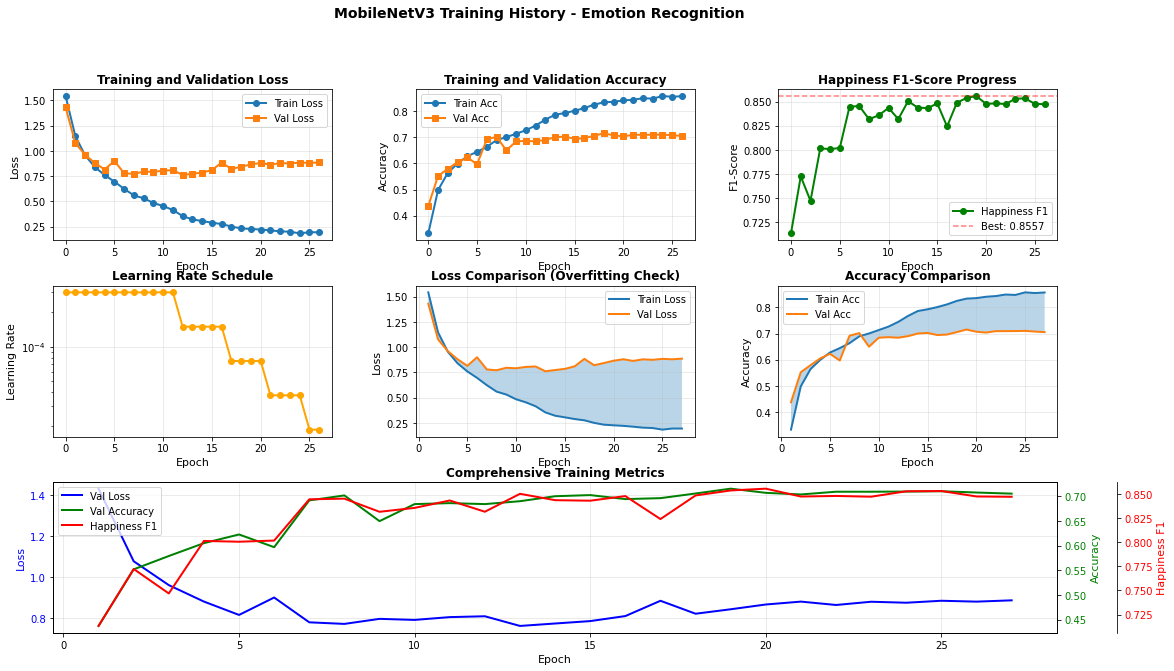


Training Summary:
Total epochs trained: 27
Best validation accuracy: 0.7154
Best happiness F1-score: 0.8557
Final learning rate: 1.87e-05
Minimum train loss: 0.1831
Minimum val loss: 0.7614



In [26]:
# ==================== 第10部分: 绘制训练曲线 ====================
def plot_training_history(history):
    """绘制详细的训练历史"""
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Loss曲线
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
    ax1.plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=11)
    ax1.set_ylabel('Loss', fontsize=11)
    ax1.set_title('Training and Validation Loss', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # 2. Accuracy曲线
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(history['train_acc'], label='Train Acc', marker='o', linewidth=2)
    ax2.plot(history['val_acc'], label='Val Acc', marker='s', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=11)
    ax2.set_ylabel('Accuracy', fontsize=11)
    ax2.set_title('Training and Validation Accuracy', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # 3. Happiness F1曲线
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.plot(history['happiness_f1'], label='Happiness F1', 
            marker='o', linewidth=2, color='green')
    ax3.axhline(y=max(history['happiness_f1']), color='r', 
               linestyle='--', alpha=0.5, label=f'Best: {max(history["happiness_f1"]):.4f}')
    ax3.set_xlabel('Epoch', fontsize=11)
    ax3.set_ylabel('F1-Score', fontsize=11)
    ax3.set_title('Happiness F1-Score Progress', fontsize=12, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    # 4. 学习率变化
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.plot(history['lr'], marker='o', linewidth=2, color='orange')
    ax4.set_xlabel('Epoch', fontsize=11)
    ax4.set_ylabel('Learning Rate', fontsize=11)
    ax4.set_title('Learning Rate Schedule', fontsize=12, fontweight='bold')
    ax4.set_yscale('log')
    ax4.grid(True, alpha=0.3)
    
    # 5. Train vs Val Loss对比
    ax5 = fig.add_subplot(gs[1, 1])
    epochs = range(1, len(history['train_loss']) + 1)
    ax5.plot(epochs, history['train_loss'], label='Train Loss', linewidth=2)
    ax5.plot(epochs, history['val_loss'], label='Val Loss', linewidth=2)
    ax5.fill_between(epochs, history['train_loss'], history['val_loss'], alpha=0.3)
    ax5.set_xlabel('Epoch', fontsize=11)
    ax5.set_ylabel('Loss', fontsize=11)
    ax5.set_title('Loss Comparison (Overfitting Check)', fontsize=12, fontweight='bold')
    ax5.legend(fontsize=10)
    ax5.grid(True, alpha=0.3)
    
    # 6. Train vs Val Accuracy对比
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.plot(epochs, history['train_acc'], label='Train Acc', linewidth=2)
    ax6.plot(epochs, history['val_acc'], label='Val Acc', linewidth=2)
    ax6.fill_between(epochs, history['train_acc'], history['val_acc'], alpha=0.3)
    ax6.set_xlabel('Epoch', fontsize=11)
    ax6.set_ylabel('Accuracy', fontsize=11)
    ax6.set_title('Accuracy Comparison', fontsize=12, fontweight='bold')
    ax6.legend(fontsize=10)
    ax6.grid(True, alpha=0.3)
    
    # 7. 所有指标综合视图
    ax7 = fig.add_subplot(gs[2, :])
    ax7_twin1 = ax7.twinx()
    ax7_twin2 = ax7.twinx()
    ax7_twin2.spines['right'].set_position(('outward', 60))
    
    p1, = ax7.plot(epochs, history['val_loss'], 'b-', label='Val Loss', linewidth=2)
    p2, = ax7_twin1.plot(epochs, history['val_acc'], 'g-', label='Val Accuracy', linewidth=2)
    p3, = ax7_twin2.plot(epochs, history['happiness_f1'], 'r-', label='Happiness F1', linewidth=2)
    
    ax7.set_xlabel('Epoch', fontsize=11)
    ax7.set_ylabel('Loss', color='b', fontsize=11)
    ax7_twin1.set_ylabel('Accuracy', color='g', fontsize=11)
    ax7_twin2.set_ylabel('Happiness F1', color='r', fontsize=11)
    ax7.set_title('Comprehensive Training Metrics', fontsize=12, fontweight='bold')
    
    ax7.tick_params(axis='y', labelcolor='b')
    ax7_twin1.tick_params(axis='y', labelcolor='g')
    ax7_twin2.tick_params(axis='y', labelcolor='r')
    
    lines = [p1, p2, p3]
    ax7.legend(lines, [l.get_label() for l in lines], loc='upper left', fontsize=10)
    ax7.grid(True, alpha=0.3)
    
    plt.suptitle('MobileNetV3 Training History - Emotion Recognition', 
                fontsize=14, fontweight='bold', y=0.995)
    
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 打印训练摘要
    print("\n" + "="*60)
    print("Training Summary:")
    print("="*60)
    print(f"Total epochs trained: {len(history['train_loss'])}")
    print(f"Best validation accuracy: {max(history['val_acc']):.4f}")
    print(f"Best happiness F1-score: {max(history['happiness_f1']):.4f}")
    print(f"Final learning rate: {history['lr'][-1]:.2e}")
    print(f"Minimum train loss: {min(history['train_loss']):.4f}")
    print(f"Minimum val loss: {min(history['val_loss']):.4f}")
    print("="*60 + "\n")

# 绘制训练历史
plot_training_history(history)



🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
FINAL EVALUATION ON TEST SET
🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯

✅ Best model loaded successfully!



Evaluating: 100%|██████████| 24/24 [00:11<00:00,  2.06it/s]



Evaluation Results
Loss: 0.8659
Overall Accuracy: 0.7070
Happiness F1-Score: 0.8557

Classification Report:
              precision    recall  f1-score   support

       Anger     0.5870    0.5000    0.5400       162
     Disgust     0.2582    0.2938    0.2749       160
        Fear     0.5493    0.5270    0.5379        74
   Happiness     0.8387    0.8734    0.8557      1185
     Sadness     0.6990    0.6025    0.6472       478
    Surprise     0.6331    0.7447    0.6844       329
     Neutral     0.6739    0.6382    0.6556       680

    accuracy                         0.7070      3068
   macro avg     0.6056    0.5971    0.5994      3068
weighted avg     0.7078    0.7070    0.7059      3068


Per-Class Metrics:
Class        Precision    Recall       F1-Score    
------------------------------------------------------------
Anger        0.5870       0.5000       0.5400      
Disgust      0.2582       0.2938       0.2749      
Fear         0.5493       0.5270       0.5379      
Happi

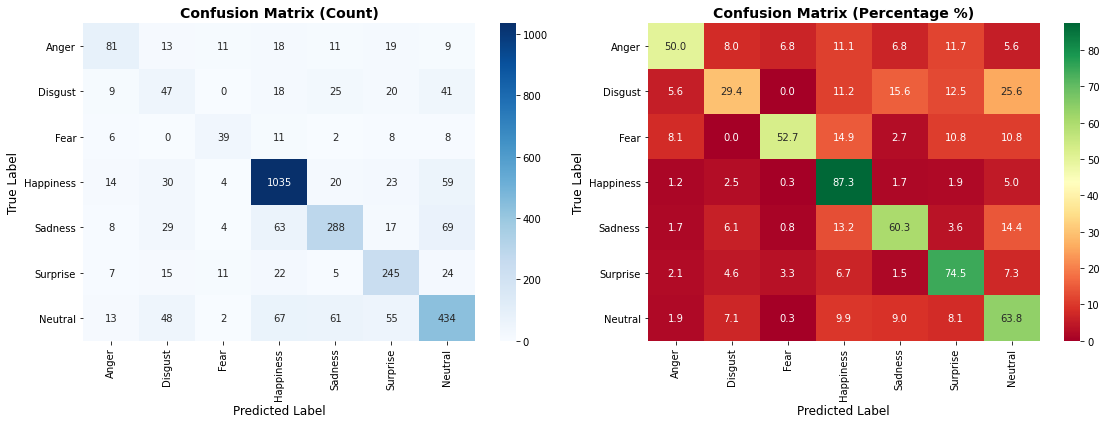


Happiness Confusion Analysis:
Total Happiness samples: 1185
Correctly predicted: 1035 (87.34%)

Misclassified as:
  Anger: 14 (1.18%)
  Disgust: 30 (2.53%)
  Fear: 4 (0.34%)
  Sadness: 20 (1.69%)
  Surprise: 23 (1.94%)
  Neutral: 59 (4.98%)


/root/miniconda3/envs/myconda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 11088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/miniconda3/envs/myconda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 11088 missing from current font.
  font.set_text(s, 0, flags=flags)


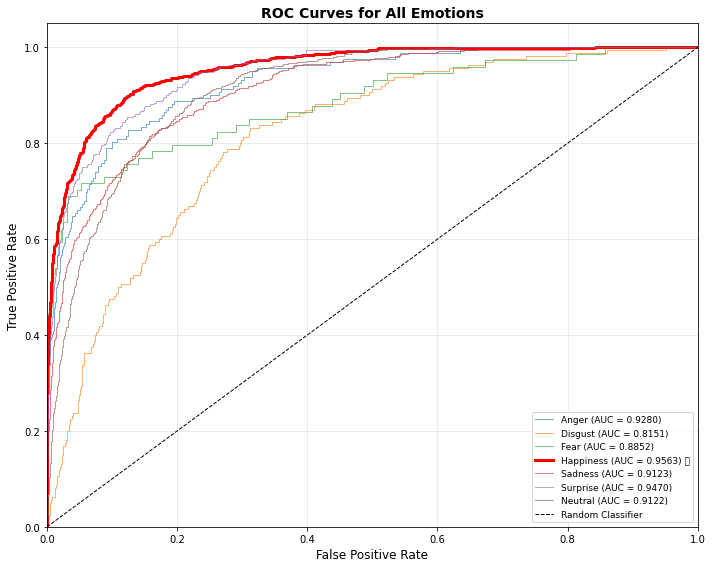


Final Test Results:
📊 Test Loss: 0.8659
🎯 Test Accuracy: 0.7070 (70.70%)
😊 Happiness F1-Score: 0.8557



In [27]:
# ==================== 第11部分: 最终评估 ====================
print("\n" + "🎯"*30)
print("FINAL EVALUATION ON TEST SET")
print("🎯"*30 + "\n")

# 加载最佳模型
model.load_state_dict(torch.load('best_emotion_model.pth'))
print("✅ Best model loaded successfully!\n")

# 详细评估
test_loss, test_acc, happiness_f1 = evaluate_model(
    model, test_loader, criterion, detailed=True
)

print(f"\n{'='*60}")
print("Final Test Results:")
print(f"{'='*60}")
print(f"📊 Test Loss: {test_loss:.4f}")
print(f"🎯 Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"😊 Happiness F1-Score: {happiness_f1:.4f}")
print(f"{'='*60}\n")
